In [1]:
# Import all libraries

import pandas as pd
import numpy as np
import glob
import os
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
rstate = 2
path = '../data_engineering/outputs/sales/'

In [3]:
# load the data
parquet_files = glob.glob(os.path.join(path, "*.parquet"))
data = pd.concat((pd.read_parquet(f) for f in parquet_files))

inputs = data[['sqfeet',
              'beds',
              'baths',
              'income',
              'density']]
              
outputs = data['price']

In [4]:
data.describe()

,sqfeet,beds,baths,income,density,price
count,546794.000000,546794.000000,546794.000000,546794.000000,546794.000000,5.467940e+05
mean,1820.117699,3.073077,2.314281,70652.892645,13422.753906,8.249511e+05
std,924.363580,1.346245,1.085194,28247.310344,24667.255859,1.336170e+06
min,100.000000,1.000000,1.000000,11368.000000,1.000000,5.000000e+02
25%,1126.000000,2.000000,2.000000,49740.000000,521.000000,2.960000e+05
50%,1600.000000,3.000000,2.000000,66583.000000,2256.000000,4.899000e+05
75%,2314.000000,4.000000,3.000000,86346.000000,13251.000000,8.390000e+05
max,5000.000000,8.000000,8.000000,230952.000000,143683.000000,4.500000e+07


In [5]:
import itertools
import matplotlib.pyplot as plt


def graph_dist(inputs):
    labels = ['sqfeet',
              'beds',
              'baths',
              'income',
              'density']
    
    fig,axs = plt.subplots(1,5,figsize=(25,5))
    for i in range(5):
        axs[i].scatter(inputs[labels[i]],inputs['price'])
        axs[i].set_xlabel(labels[i])
        axs[i].set_ylabel("Price")
    plt.tight_layout()
    return fig, axs


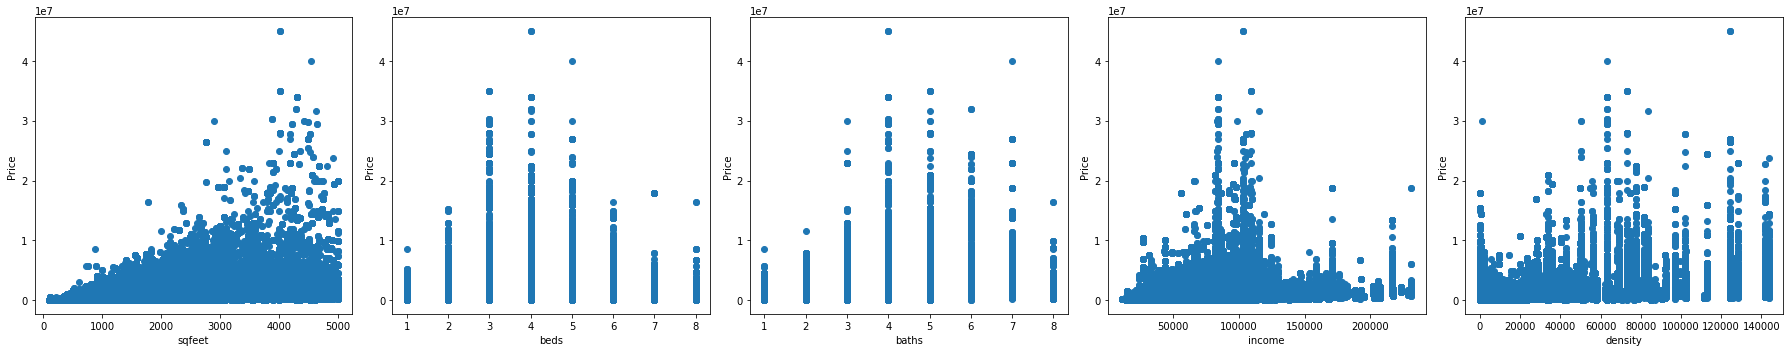

In [6]:
fig, axs = graph_dist(data)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size = 0.2, random_state=rstate)

### Trying Models, evaluating, and saving them

Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

linmodel = LinearRegression()
linmodel.fit(x_train, y_train)

LinearRegression()

In [9]:
linmodel.score(x_test, y_test)

0.3785061900982307

In [10]:
linmodel.predict(x_test)

array([-374042.48580555,  647480.2186743 ,  902884.68453545, ...,
        983319.29200659, 1506750.85431256, 1432537.3511473 ])

In [11]:
ridgemodel = Ridge()
ridgemodel.fit(x_train, y_train)

Ridge()

In [12]:
ridgemodel.score(x_test, y_test)

0.37850618298591787

In [13]:
ridgemodel.predict(x_test)

array([-374041.58563127,  647479.37069195,  902887.01361315, ...,
        983320.30737108, 1506749.34628427, 1432537.61592226])

In [14]:
lassomodel = Lasso()
lassomodel.fit(x_train, y_train)

Lasso()

In [15]:
lassomodel.score(x_test, y_test)

0.3785061769860931

In [16]:
lassomodel.predict(x_test)

array([-374040.59621807,  647478.58952065,  902889.80089863, ...,
        983321.15019757, 1506748.66276324, 1432537.10974036])

In [17]:
import eli5
eli5.show_weights(lassomodel, feature_names = inputs.columns.tolist())

Weight?,Feature
+310747.336,baths
+370.033,sqfeet
+24.346,density
+5.619,income
-117043.747,beds
-932012.581,<BIAS>


In [18]:
pickle.dump(linmodel, open('./outputs/sale_models/linmodel.pkl', 'wb'))
pickle.dump(ridgemodel, open('./outputs/sale_models/ridgemodel.pkl', 'wb'))
pickle.dump(lassomodel, open('./outputs/sale_models/lassomodel.pkl', 'wb'))

Decision Tree

In [19]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(random_state=rstate)
dtree.fit(x_train, y_train)

DecisionTreeRegressor(random_state=2)

In [20]:
dtree.score(x_test, y_test)

0.9726284594785054

In [21]:
dtree.predict(x_test)

array([  62500.        ,  423250.        ,  799999.        , ...,
        625000.        , 1490000.        ,  362679.48717949])

In [22]:
# Tuning dtree parameters
dtree_search = GridSearchCV(dtree, param_grid={
        'max_depth':np.arange(10, 100, 10),
        }, cv=2)
dtree_search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % dtree_search.best_score_)
print(dtree_search.best_params_)

Best parameter (CV score=0.961):
{'max_depth': 40}


In [23]:
pickle.dump(dtree, open('./outputs/sale_models/decision_tree.pkl', 'wb'))
pickle.dump(dtree_search, open('./outputs/sale_models/decision_tree_gridsearch.pkl', 'wb'))

Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor

randforest = RandomForestRegressor(random_state=rstate)
randforest.fit(x_train, y_train)

RandomForestRegressor(random_state=2)

In [9]:
randforest.score(x_test, y_test)

0.9858775290059424

In [26]:
randforest.predict(x_test)

array([  62500.        ,  423250.        ,  799999.        , ...,
        625000.        , 1490000.        ,  365853.90733083])

In [10]:
randforest_search = GridSearchCV(randforest, param_grid={
        'n_estimators':np.arange(100,300,50),
        'max_depth': np.arange(50,200,50)
        }, cv=2)
randforest_search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % randforest_search.best_score_)
print(randforest_search.best_params_)

Best parameter (CV score=0.971):
{'max_depth': 100, 'n_estimators': 200}


In [11]:
randforest_search.score(x_test, y_test)

0.9857353197577481

In [12]:
randforest_search.predict(x_test)

array([  62500.       ,  423250.       ,  799999.       , ...,
        625000.       , 1490000.       ,  362997.4175569])

In [13]:
pickle.dump(randforest, open('./outputs/sale_models/random_forest.pkl', 'wb'))
pickle.dump(randforest_search, open('./outputs/sale_models/randforest_search.pkl', 'wb'))

XGBoost

In [28]:
from xgboost import XGBRegressor

xgb = XGBRegressor(seed=rstate)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=2, ...)

In [29]:
xgb.score(x_test, y_test)

0.9300482989726243

In [30]:
xgb.predict(x_test)

array([ 250382.78,  470265.25,  935445.5 , ...,  610710.25, 1346283.5 ,
        405640.5 ], dtype=float32)

In [31]:
xgb_search = GridSearchCV(xgb, param_grid={
        'n_estimators':np.arange(100,300,50),
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
        }, cv=2)
xgb_search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % xgb_search.best_score_)
print(xgb_search.best_params_)

Best parameter (CV score=0.944):
{'learning_rate': 0.3, 'n_estimators': 250}


In [32]:
xgb_search.predict(x_test)

array([ 269137.16,  449134.16,  797465.25, ...,  633888.94, 1405569.1 ,
        390447.4 ], dtype=float32)

In [33]:
xgb = XGBRegressor(seed=rstate, learning_rate=0.3, n_estimators=250)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=250, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=2, ...)

In [34]:
xgb.score(x_test, y_test)

0.9564228846346995

In [35]:
pickle.dump(xgb, open('./outputs/sale_models/xgb.pkl', 'wb'))
pickle.dump(xgb_search, open('./outputs/sale_models/xgb_gridsearch.pkl', 'wb'))

CatBoost

In [36]:
from catboost import CatBoostRegressor

catboost = CatBoostRegressor(random_seed=rstate, verbose=False)
catboost.fit(x_train, y_train)

In [37]:
catboost.score(x_test, y_test)

0.9162868447980871

In [38]:
catboost.predict(x_test)

array([ 234735.069423  ,  544288.22858113,  830770.51769499, ...,
        531214.50867178, 1366486.73792084,  411241.93690002])

In [39]:
catboost_search = GridSearchCV(catboost, param_grid={
        'n_estimators':np.arange(100,300,50),
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
        }, cv=2)
catboost_search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % catboost_search.best_score_)
print(catboost_search.best_params_)

Best parameter (CV score=0.894):
{'learning_rate': 0.3, 'n_estimators': 250}


In [40]:
catboost_search.predict(x_test)

array([ 231580.93983224,  540062.69880044,  776930.7333461 , ...,
        538108.93740286, 1406745.20259288,  427408.32868359])

In [41]:
pickle.dump(catboost, open('./outputs/sale_models/catboost.pkl', 'wb'))
pickle.dump(catboost_search, open('./outputs/sale_models/catboost_gridsearch.pkl', 'wb'))

K-Nearest-Neighbors

In [9]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(x_train, y_train)

KNeighborsRegressor()

In [10]:
knn.score(x_test, y_test)

0.9635025213757172

In [11]:
x_test.iloc[0]

sqfeet       792.0
beds           3.0
baths          1.0
income     53112.0
density      282.0
Name: 120762, dtype: float64

In [12]:
knn.predict([x_test.iloc[0]])

/Users/nathanyee/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


array([62500.])

In [13]:
y_test.iloc[0]

62500.0

In [14]:
knn.predict(x_test)

array([  62500.,  423250.,  799999., ...,  625000., 1490000.,  306200.])

In [48]:
knn_search = GridSearchCV(knn, param_grid={
        'n_neighbors':np.arange(1, 50),
        }, cv=2)
knn_search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % knn_search.best_score_)
print(knn_search.best_params_)

Best parameter (CV score=0.956):
{'n_neighbors': 1}


In [15]:
pickle.dump(knn, open('./outputs/sale_models/knn.pkl', 'wb'))
pickle.dump(knn_search, open('./outputs/sale_models/knn_gridsearch.pkl', 'wb'))

Tensorflow Neural Network

In [50]:
# Keras NN model to be created
def create_model(inputs, outputs):
    input_layer = Input(shape=(5, ))
    x1 = Dense(15, activation='relu', kernel_initializer='normal') (input_layer)
    x2 = Dense(5, activation='relu', kernel_initializer='normal') (x1)
    x3 = Dense(3, activation='relu', kernel_initializer='normal') (x2)
    output = Dense(1, activation='linear', kernel_initializer='normal') (x3)

    t_model = Model(inputs=input_layer, outputs=output)

    t_model.compile(
        loss='mean_squared_error', 
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["mean_squared_error"]
    )
    
    t_model.fit(inputs, outputs, epochs=350, batch_size=1000, verbose=True)
    return t_model

In [51]:
nn_model = create_model(x_train, y_train)

2022-11-26 00:52:51.941866: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/350
438/438 [==============================] - 2s 2ms/step - loss: 2144522076160.0000 - mean_squared_error: 2144522076160.0000
Epoch 2/350
438/438 [==============================] - 1s 2ms/step - loss: 1396063469568.0000 - mean_squared_error: 1396063469568.0000
Epoch 3/350
438/438 [==============================] - 1s 2ms/step - loss: 1350574407680.0000 - mean_squared_error: 1350574407680.0000
Epoch 4/350
438/438 [==============================] - 1s 2ms/step - loss: 1338301612032.0000 - mean_squared_error: 1338301612032.0000
Epoch 5/350
438/438 [==============================] - 1s 1ms/step - loss: 1331414958080.0000 - mean_squared_error: 1331414958080.0000
Epoch 6/350
438/438 [==============================] - 1s 1ms/step - loss: 1324256722944.0000 - mean_squared_error: 1324256722944.0000
Epoch 7/350
438/438 [==============================] - 1s 1ms/step - loss: 1316214538240.0000 - mean_squared_error: 1316214538240.0000
Epoch 8/350
438/438 [==============================] - 

In [52]:
x_test.iloc[0]

sqfeet       792.0
beds           3.0
baths          1.0
income     53112.0
density      282.0
Name: 120762, dtype: float64

In [53]:
y_test.to_numpy()

array([  62500.,  423250.,  799999., ...,  625000., 1490000.,  225000.])

In [54]:
y_pred = nn_model.predict(x_test)
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.3293808485596563

In [55]:
nn_model.evaluate(x_test, y_test)

3418/3418 [==============================] - 10s 3ms/step - loss: 1252952899584.0000 - mean_squared_error: 1252952899584.0000


[1252952899584.0, 1252952899584.0]

In [56]:
nn_model.save('./outputs/sale_models/nn_model.h5')

In [57]:
# Tune the model
import keras_tuner
from kerastuner.tuners import RandomSearch

/var/folders/4p/0tpbwp7d5fj91r2jb64xf4kh0000gn/T/ipykernel_11788/1460629663.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [58]:
def build_model(hp):
    input_layer = Input(shape=(5, ))
    x1 = Dense(hp.Choice('firstlayer', [16,24,32]), activation=hp.Choice("x1_activation", ['relu', 'sigmoid', 'tanh']), kernel_initializer='normal')(input_layer)
    x2 = Dense(hp.Choice('secondlayer', [4,5,8,16]), activation=hp.Choice("x2_activation", ['relu', 'sigmoid', 'tanh']), kernel_initializer='normal')(x1)
    x3 = Dense(hp.Choice('thirdlayer', [3,4,5,6,7,8]), activation=hp.Choice("x3_activation", ['relu', 'sigmoid', 'tanh']), kernel_initializer='normal')(x2)
    output = Dense(1, activation='linear', kernel_initializer='normal')(x3)

    t_model = Model(inputs=input_layer, outputs=output)

    t_model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])),
        metrics=["mean_squared_error"]
    )
    return t_model


In [59]:
tuner = RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 20
)
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [60]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
firstlayer (Choice)
{'default': 16, 'conditions': [], 'values': [16, 24, 32], 'ordered': True}
x1_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
secondlayer (Choice)
{'default': 4, 'conditions': [], 'values': [4, 5, 8, 16], 'ordered': True}
x2_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
thirdlayer (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4, 5, 6, 7, 8], 'ordered': True}
x3_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [61]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
firstlayer: 16
x1_activation: relu
secondlayer: 4
x2_activation: tanh
thirdlayer: 8
x3_activation: relu
learning_rate: 0.001
Score: 336496.28125
Trial summary
Hyperparameters:
firstlayer: 24
x1_activation: tanh
secondlayer: 8
x2_activation: relu
thirdlayer: 8
x3_activation: sigmoid
learning_rate: 0.01
Score: 336496.375
Trial summary
Hyperparameters:
firstlayer: 16
x1_activation: sigmoid
secondlayer: 8
x2_activation: relu
thirdlayer: 3
x3_activation: tanh
learning_rate: 0.1
Score: 336496.5
Trial summary
Hyperparameters:
firstlayer: 24
x1_activation: tanh
secondlayer: 16
x2_activation: tanh
thirdlayer: 4
x3_activation: tanh
learning_rate: 0.01
Score: 336496.53125
Trial summary
Hyperparameters:
firstlayer: 32
x1_activation: tanh
secondlayer: 16
x2_activation: tanh
thirdlayer: 6
x3_activation: relu
learning_rate: 0.01
Score: 336498.84375
Trial summary
Hyperparameters:
firstlayer: 16
x1_activ